Thursday To-Do List:
~~~1. Get more pictures for testing~~~
~~~2. Figure out the proper evaluation metrics (signal/noise, etc...)~~~
~~~3. Make a seperate method for evaluation~~~
4. Do statistical tests to prove SPIR is accurate
5. Make a method/function for testing and graphing results and saving images
6. Make a default list of parameters, make the parameters option optional, make it easier to change
7. Show that/if replacing unused atoms gives better results
8. Run tests on other toggles in the algorithm
9. Test you crazy idea about rescaling the sparse reps to acount for stuff in the demosaicing process

## Evaluation Metrics

The simplest and most intuitive evalutation metric is the Mean Square Error ($MSE$)
$$MSE = \frac{1}{d}|| y - x ||_2^2$$
between a signal $y$ and its approximation $x$.
However a standard in the industry is to use Peak Signal to Noise Ratio ($PSNR$)
$$ PSNR = 10 \log_{10}\Big( \frac{ ||y||_\infty^2}{ \frac{1}{d}||y - x ||_2^2}\Big) $$
which since the majority of signals will have $||y||_\infty \approx 255$, the $PSNR$ has a logrithmic relation to the $MSE$, and therefore contain an identical amount of information.

Another standard evaluation metric is the Structural Similarity Index Measure ($SSIM$),
$$ SSIM(y, x) = l(y, x) c(y, x) s(y,x), $$
which is the product of three distortion measurements. This takes values in $[-1,1]$ where higher is better. Note that this value is in practice never negative, ast that would require special engineering, so we consider it as a value in $[0,1]$.
Luminance Distortion
$$ l(y,x) = \frac{2 \mu_y \mu_x + C_l}{\mu_y^2 + \mu_x^2 + C_l} $$
Contrast Distortion
$$ c(y,x) = \frac{2 \sigma_y \sigma_x + C_c}{\sigma_Y ^2 + \sigma_x^2 + C_c} $$
Structural Comparison
$$ s(y,x) = \frac{ \sigma_{yx} ++ C_s}{ \sigma_Y \sigma_x + C_s} $$
where
$$\mu_x = \frac{1}{d} \sum x^{(i)} $$
$$\sigma_x^2 = \frac{1}{d} \sum(x^{(i)} - \mu_x)^2 $$
$$\sigma_{xy} = \frac{1}{d} \sum (x^{(i)} - \mu_x)(y^{(i)} - \mu_y) $$

These metrics give an idea of what area an image reconstruction is doing better or worse on.

We will measure all of these qnatities, plus run-time (as a proxy for "compute") and gain (the improvement of these metrics). We will typically only display the $PSNR$, however when a more indepth analysis is called for, we will display the rest.

*A comparison of these metrics is found in here https://ietresearch.onlinelibrary.wiley.com/doi/epdf/10.1049/iet-ipr.2012.0489

In [261]:
import numpy as np
import random
import cv2
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import time

%run Classes.py

In [27]:
paths = ['Compressed Images/cheese_board.jpg', 'Compressed Images/chicken_n_beans.jpg', 'Compressed Images/persimmon_tomato_salad.jpg', 'Compressed Images/octopus.jpg']
new_path = 'Reconstructed Images/tea_eggs'
path_orig = 'Compressed Images/tea_eggs.jpg'
path_corrupted = 'Compressed Images/tea_eggs_corrupted.jpg'

sam = Sampler(paths = paths, patch_shape = np.array([8,8]), num_samples = 500)
sam.add_filter('noise', std = 100)
learner = DictionaryLearner(L=2, K=200, sampler=sam, algo = 'OMP')
learner.update_step(use_orig=True)

img_orig = load_image(path_orig)
img_corrupt = sam.filter(img_orig)

cv2.imwrite(path_corrupted, img_corrupt)

cv2.imshow("Original Image", img_orig)
cv2.imshow("Corrupted Image", img_corrupt)
cv2.moveWindow("Corrupted Image", img_orig.shape[1], 0)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [28]:
D = learner.sparse_dictionary_learning(iters=1, output=True)
print("Dictionary Complete")

  0%|          | 0/1 [00:00<?, ?it/s]

Dictionary Complete


In [29]:
error_values = learner.SPIR_test(path_corrupted, apply_filter=True, min_count=2, replacement=True)
error_values

  0%|          | 0/27599 [00:00<?, ?it/s]

,MSE,RMSE,PSNR,SSIM,Luminance Dist.,Contrast Dist.,Structural Comp.
0.003623,4261.993386,65.283944,11.834676,0.390029,0.999997,0.687215,0.567553
0.007247,3938.571735,62.758041,12.177416,0.438738,0.999993,0.735802,0.596276
0.010870,3906.970625,62.505765,12.212402,0.430081,0.999999,0.729262,0.589749
0.014493,3898.376091,62.436977,12.221966,0.417978,0.999994,0.718134,0.582037
0.018117,3804.862685,61.683569,12.327414,0.417936,0.999996,0.711563,0.587352
...,...,...,...,...,...,...,...
0.981920,3552.379139,59.601838,12.625610,0.418034,0.999999,0.602858,0.693420
0.985543,3552.415837,59.602146,12.625566,0.418023,0.999999,0.602838,0.693425
0.989166,3552.449119,59.602425,12.625525,0.418018,0.999999,0.602838,0.693416
0.992790,3552.620576,59.603864,12.625315,0.417976,0.999999,0.602781,0.693412


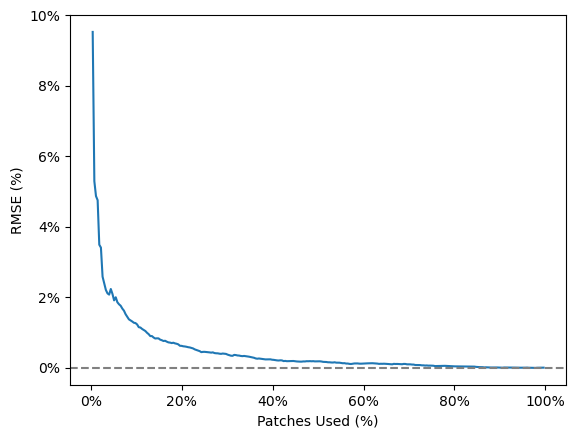

In [30]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_error_values(df, column):
    # Extract the last value of the input column
    column_true = df[column].iloc[-1]

    # Create the x and y values for the line graph
    x_values = df.index * 100
    y_values = (df[column] / column_true - 1) * 100

    # Create the line graph
    fig, ax = plt.subplots()
    ax.plot(x_values, y_values)

    # Set the x and y axis labels and tick formats
    ax.set_xlabel("Patches Used (%)")
    ax.set_ylabel(f"{column} (%)")
    ax.xaxis.set_major_formatter('{x:.0f}%')
    ax.yaxis.set_major_formatter('{x:.0f}%')

    # Add a horizontal dashed line at y=0
    ax.axhline(y=0, color='grey', linestyle='--')

    # Show the plot
    plt.show()

plot_error_values(error_values, "RMSE")


## SPIR Tests

Here we are going to prove the SPIR is a reliable, robust, and quick method of estimating the error of a reconstructed photo. We will do that by measuring the error using 5 different metrics: $PSNR$, $SSIM$, and the 3 components of $SSIM$ individually. We will be doing this on three different "tests".

**Test 1 - "Milanese"**
A simple reconstuction test on a $200\times 150$ pixel black and white photo of chicken "Milanese", where the training data is the same image. Parameters are: L=5, K=100, N=300, iters=10, patch_shape = [8,8]

**Test 2 - "Tea Eggs"**
A denoising test on a $200\times 150$ pixel black and white photo of "Tea Eggs". The training data will be 4 other photos of the same size. The added noise has std = 100. The parameters are: L = 10, K = 200, N = 500, iters = 20, patch_shape = [8,8]

**Test 3 - "Persimmon Salad"**
A color-adding test on a $200\times 150$ pixel "RB0" photo (missing the green channel) of a "Persimmon Salad". The training data will be 9 other similarly sized and colored photos. The parameters are: L = 5, K = 200, N = 800, iters = 10, patch_shape = [8,8,3]

In [262]:
### Test 1 - "Milanese"

# Get Training and Testing data
path = 'Compressed Images/milanese.jpg'
paths = [path]

# Set parameters
L = 5
K = 100
N = 300
iters = 10
patch_shape = np.array([8,8])

# Initialize Sampler
sam_milanese = Sampler(paths = paths, patch_shape = patch_shape, num_samples = N)
sam_milanese.add_filter(None)

# Initialize Learner
learner_milanese = DictionaryLearner(L=L, K=K, sampler=sam_milanese, algo = 'OMP')
learner_milanese.update_step(use_orig=True)

# Train Dictionary
D_milanese = learner_milanese.sparse_dictionary_learning(iters=iters, output=True)
print("Dictionary is trained")

# Begin Stochastic Partial Image Reconstruction
errors_milanese = learner_milanese.SPIR_test(path, apply_filter=False, min_count=1, replacement=False)

# Display Results
errors_milanese

  0%|          | 0/10 [00:00<?, ?it/s]

Dictionary is trained


,MSE,RMSE,PSNR,SSIM,Luminance Dist.,Contrast Dist.,Structural Comp.
0.000000,424.125000,20.594295,18.926489,0.938401,0.999407,0.999895,0.939057
0.003623,145.715355,12.071262,26.495750,0.976394,0.999980,0.999707,0.976701
0.007247,128.320345,11.327857,27.047848,0.976859,0.999979,0.999680,0.977193
0.010870,130.439218,11.420999,26.976722,0.977770,0.999982,0.999650,0.978130
0.014493,122.489852,11.067513,27.249802,0.980339,0.999985,0.999720,0.980628
...,...,...,...,...,...,...,...
0.981920,54.732953,7.398172,30.748315,0.990668,1.000000,0.999428,0.991235
0.985543,54.719088,7.397235,30.749415,0.990670,1.000000,0.999428,0.991237
0.989166,54.739351,7.398605,30.747807,0.990666,1.000000,0.999427,0.991234
0.992790,54.715840,7.397016,30.749673,0.990670,1.000000,0.999428,0.991238


In [260]:
#learner_milanese.SPIR(percent=.05, recon_image_path='Reconstructed Images/milanese_p=05.jpg')



TypeError: SPIR() got an unexpected keyword argument 'recon_image_path'

In [265]:
### Test 2 - "Tea Eggs"

# Get Training and Testing data
path = 'Compressed Images/tea_eggs_corrupted.jpg'
paths = ['Compressed Images/cheese_board.jpg', 'Compressed Images/chicken_n_beans.jpg', 'Compressed Images/persimmon_tomato_salad.jpg', 'Compressed Images/octopus.jpg']

# Set parameters
L = 10
K = 200
N = 500
iters = 20
patch_shape = np.array([8,8])

# Initialize Sampler
sam_tea_eggs = Sampler(paths = paths, patch_shape = patch_shape, num_samples = N)
sam_tea_eggs.add_filter("noise", std = 100)

# Initialize Learner
learner_tea_eggs = DictionaryLearner(L=L, K=K, sampler=sam_tea_eggs, algo = 'OMP', Dictionary = D_tea_eggs, previous_iters=20)
learner_tea_eggs.update_step(use_orig=True)

# Train Dictionary
D_tea_eggs = learner_tea_eggs.sparse_dictionary_learning(iters=iters, output=True)
#print("Dictionary is trained")

# Begin Stochastic Partial Image Reconstruction
#errors_tea_eggs = learner_tea_eggs.SPIR_test(path, apply_filter=False, min_count=1, replacement=False)

# Display Results
errors_tea_eggs

  0%|          | 0/20 [00:00<?, ?it/s]

,MSE,RMSE,PSNR,SSIM,Luminance Dist.,Contrast Dist.,Structural Comp.
0.000000,3611.796875,60.098227,12.450778,0.224342,0.999994,0.620195,0.361731
0.003623,2901.839340,53.868723,13.504070,0.531541,0.999995,0.879308,0.604502
0.007247,2815.761126,53.063746,13.634846,0.552075,0.999995,0.886248,0.622938
0.010870,2807.610009,52.986885,13.647436,0.556345,0.999995,0.885665,0.628169
0.014493,2746.472484,52.406798,13.743051,0.566329,0.999996,0.888356,0.637505
...,...,...,...,...,...,...,...
0.981920,2467.822301,49.677181,14.207665,0.594902,1.000000,0.841844,0.706666
0.985543,2467.685779,49.675807,14.207905,0.594918,1.000000,0.841828,0.706698
0.989166,2467.742967,49.676382,14.207804,0.594903,1.000000,0.841814,0.706692
0.992790,2467.857248,49.677533,14.207603,0.594887,1.000000,0.841820,0.706667


In [268]:
learner_tea_eggs.SPIR(percent = .05, path = 'Compressed Images/tea_eggs_corrupted.jpg', recon_image_path = 'Reconstructed Images/tea_eggs_p=05.jpg')
learner_tea_eggs.SPIR(percent = 1, path = 'Compressed Images/tea_eggs_corrupted.jpg', recon_image_path = 'Reconstructed Images/tea_eggs_p=95.jpg')

  0%|          | 0/1379 [00:00<?, ?it/s]

C:\Users\raino\GitHub\Sparse-Dictionary-Learning\Classes.py:594: RuntimeWarning: invalid value encountered in floor_divide
  recon_img = recon_img // count
C:\Users\raino\GitHub\Sparse-Dictionary-Learning\Classes.py:796: RuntimeWarning: divide by zero encountered in log10
  PSNR_Corrupt = 10 * (2 * np.log10(peak_signal) - np.log10(MSE_corrupt))


  0%|          | 0/27599 [00:00<?, ?it/s]

C:\Users\raino\GitHub\Sparse-Dictionary-Learning\Classes.py:796: RuntimeWarning: divide by zero encountered in log10
  PSNR_Corrupt = 10 * (2 * np.log10(peak_signal) - np.log10(MSE_corrupt))


(array([[151, 176, 155, ..., 106, 143, 166],
        [158, 131, 102, ..., 115, 139, 183],
        [151, 123, 123, ..., 112, 137, 162],
        ...,
        [153, 158, 185, ..., 106, 109, 109],
        [184, 165, 153, ..., 112, 101, 100],
        [149, 172, 122, ..., 111,  98,  98]], dtype=uint8),
 50.222341113925914)

In [273]:
### Test 3 - "Persimmon Salad"

# Get Training and Testing data
path = 'Compressed Images/persimmon_tomato_salad_color.jpg'
temp_paths = ['easter_egg_bread.jpg', 'burger.jpg', 'granita.jpg', 'pizzelle.jpg', 'pork_knuckle.jpg', 'cheese_board.jpg', 'chicken_n_beans.jpg', 'octopus.jpg', 'tea_eggs.jpg']
paths = ['Compressed Images/' + p[:-4] + "_color.jpg" for p in temp_paths]

# Set parameters
L = 5
K = 200
N = 800
iters = 10
patch_shape = np.array([8,8,3])

# Initialize Sampler
sam_persimon_salad= Sampler(paths = paths, patch_shape = patch_shape, num_samples = N)
sam_persimon_salad.add_filter("RB0")

# Initialize Learner
learner_persimon_salad = DictionaryLearner(L=L, K=K, sampler=sam_persimon_salad, algo = 'OMP')
learner_persimon_salad.update_step(use_orig=True)

# Train Dictionary
D_persimon_salad = learner_persimon_salad.sparse_dictionary_learning(iters=iters, output=True)
print("Dictionary is trained")

# Begin Stochastic Partial Image Reconstruction
#errors_persimon_salad = learner_persimon_salad.SPIR_test(path, apply_filter=True, min_count=1, replacement=False)

# Display Results
errors_persimon_salad

  0%|          | 0/10 [00:00<?, ?it/s]

Dictionary is trained


,MSE,RMSE,PSNR,SSIM,Luminance Dist.,Contrast Dist.,Structural Comp.
0.000000,11016.401042,104.959045,5.643524,-0.150670,0.459604,0.410644,-0.798322
0.003623,7720.059098,87.863867,9.254597,0.217374,0.779910,0.975596,0.285689
0.007247,7700.831037,87.754379,9.265428,0.222215,0.784021,0.976097,0.290371
0.010870,7376.622604,85.887267,9.452228,0.229685,0.774837,0.971353,0.305173
0.014493,7246.352978,85.125513,9.529609,0.231154,0.772761,0.969596,0.308507
...,...,...,...,...,...,...,...
0.981920,6903.926607,83.089871,9.739842,0.243118,0.772275,0.964002,0.326563
0.985543,6904.111984,83.090986,9.739725,0.243105,0.772279,0.964008,0.326542
0.989166,6904.053612,83.090635,9.739762,0.243104,0.772281,0.964003,0.326542
0.992790,6903.841688,83.089360,9.739895,0.243115,0.772280,0.963996,0.326559


In [274]:
learner_persimon_salad.SPIR(percent = .05, path = 'Compressed Images/persimmon_tomato_salad_color.jpg', apply_filter = True, recon_image_path = 'Reconstructed Images/persimmon_tomato_salad_p=05.jpg')
learner_persimon_salad.SPIR(percent = 1, path = 'Compressed Images/persimmon_tomato_salad_color.jpg', apply_filter = True, recon_image_path = 'Reconstructed Images/persimmon_tomato_salad_p=95.jpg')

  0%|          | 0/1379 [00:00<?, ?it/s]

C:\Users\raino\GitHub\Sparse-Dictionary-Learning\Classes.py:594: RuntimeWarning: invalid value encountered in floor_divide
  recon_img = recon_img // count


  0%|          | 0/27599 [00:00<?, ?it/s]

(array([[[19, 22,  0],
         [17, 22,  0],
         [19, 27,  2],
         ...,
         [ 4,  6,  0],
         [ 4,  6,  0],
         [ 4,  5,  0]],
 
        [[19, 22,  0],
         [18, 22,  0],
         [20, 27,  0],
         ...,
         [ 3,  5,  0],
         [ 3,  5,  0],
         [ 3,  5,  0]],
 
        [[20, 23,  0],
         [17, 22,  0],
         [18, 24,  0],
         ...,
         [ 3,  5,  0],
         [ 3,  5,  0],
         [ 3,  5,  0]],
 
        ...,
 
        [[ 4, 11,  0],
         [ 4, 10,  0],
         [ 4,  9,  0],
         ...,
         [ 5, 12,  0],
         [ 3, 11,  0],
         [ 3, 10,  0]],
 
        [[ 5, 10,  0],
         [ 4, 10,  0],
         [ 4, 10,  0],
         ...,
         [ 2, 10,  0],
         [ 1,  9,  0],
         [ 1,  8,  0]],
 
        [[ 5, 11,  0],
         [ 5, 10,  0],
         [ 5, 10,  0],
         ...,
         [ 1,  8,  0],
         [ 0,  6,  0],
         [ 0,  6,  0]]], dtype=uint8),
 9.8919580078125)

In [276]:
img_orig = load_image('Compressed Images/persimmon_tomato_salad_color.jpg')

img_corrupt = sam_persimon_salad.filter(img_orig)

cv2.imwrite('Compressed Images/persimmon_tomato_salad_RB0.jpg', img_corrupt)

True

In [163]:
import matplotlib.pyplot as plt

def plot_error_values(dfs, column, path):
    fig, ax = plt.subplots()

    # Loop over the list of data frames
    for i, df in enumerate(dfs):
        # Extract the last value of the input column
        column_true = df[column].iloc[-1]

        # Create the x and y values for the line graph
        x_values = df.index * 100
        y_values = (df[column] / column_true - 1) * 100

        # Create the line graph with different colors or line styles
        if i == 0:
            ax.plot(x_values, y_values, color='blue', label=f'Milanese {column_true:.2f}')
        elif i == 1:
            ax.plot(x_values, y_values, color='red',  label=f'Tea Eggs {column_true:.2f}')
        else:
            ax.plot(x_values, y_values, color='green', label=f'Persimmon Salad {column_true:.2f}')

    # Set the x and y axis labels and tick formats
    ax.set_xlabel("Patches Used (% of Total)")
    ax.set_ylabel(f"{column} (% Deviation)")
    ax.xaxis.set_major_formatter('{x:.0f}%')
    ax.yaxis.set_major_formatter('{x:.0f}%')

    # Set the y-axis scale to logarithmic
    ax.set_yscale('symlog')

    # Format the y-axis tick labels to be percentages with more tick marks
    #y_ticks = np.logspace(-10, 0, 11)
    #y_ticks = -1 * np.logspace(-4,1,5)
    #y_tick_labels = [f"{int(tick)}%" if tick != -10 else "-10%" for tick in y_ticks]
    y_ticks = [-10, -2,  -1, -.5, 0]
    y_tick_labels = ["-10%", "-2%", "-1%", "-0.5%", "0%"]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_tick_labels)

    # Add a horizontal dashed line at y=0
    ax.axhline(y=0, color='grey', linestyle='--')

    # Add a legend to the plot
    ax.legend()

    ax.set_title('% Deviation from True SSIM Value')

    plt.savefig(path)

    # Show the plot
    plt.show()

In [226]:
def plot_error_values(dfs, column, path):
    fig, ax = plt.subplots()

    # Loop over the list of data frames
    for i, df in enumerate(dfs):
        # Extract the last value of the input column
        column_true = df[column].iloc[-1]

        # Create the x and y values for the line graph
        x_values = df.index * 100
        y_values = (df[column] / column_true - 1) * 100

        # Create the line graph with different colors or line styles
        if i == 0:
            ax.plot(x_values, y_values, color='blue', label=f'Milanese {column_true:.2f}')
        elif i == 1:
            ax.plot(x_values, y_values, color='red',  label=f'Tea Eggs {column_true:.2f}')
        else:
            ax.plot(x_values, y_values, color='green', label=f'Persimmon Salad {column_true:.2f}')

    # Set the x and y axis labels and tick formats
    ax.set_xlabel("Patches Used (% of Total)")
    ax.set_ylabel(f"{column} (% Deviation)")
    ax.xaxis.set_major_formatter('{x:.0f}%')
    ax.yaxis.set_major_formatter('{x:.0f}%')

    # Set the y-axis scale to logarithmic
    ax.set_yscale('symlog')

    # Format the y-axis tick labels to be percentages with more tick marks
    y_ticks_major = [-10, -1, 0]
    y_tick_labels_major = ["-10%", "-1%", "0%"]
    ax.set_yticks(y_ticks_major)
    ax.set_yticklabels(y_tick_labels_major)

    y_ticks_minor = [-9, -8, -7, -6, -5, -4, -3, -2] + [-.9, -.8,  -.7, -.6, -.5, -.4, -.3, -.2, -.1]#+ [-0.9, -0.8, -0.7 ,-0.6, -0.5, -0.4, -0.3, -0.2, -0.1]
    #y_tick_labels_minor = ["", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", ""]
    y_tick_labels_minor = len(y_ticks_minor) * [""]
    ax.set_yticks(y_ticks_minor, minor=True)
    ax.set_yticklabels(y_tick_labels_minor, minor=True)

    # Add a horizontal dashed line at y=0
    ax.axhline(y=0, color='grey', linestyle='--')

    # Add a legend to the plot
    ax.legend()

    ax.set_title('% Deviation from True SSIM Value')

    #plt.savefig(path)

    # Show the plot
    plt.show()


In [227]:
[1,"2",3] + [1,4,5]

[1, '2', 3, 1, 4, 5]

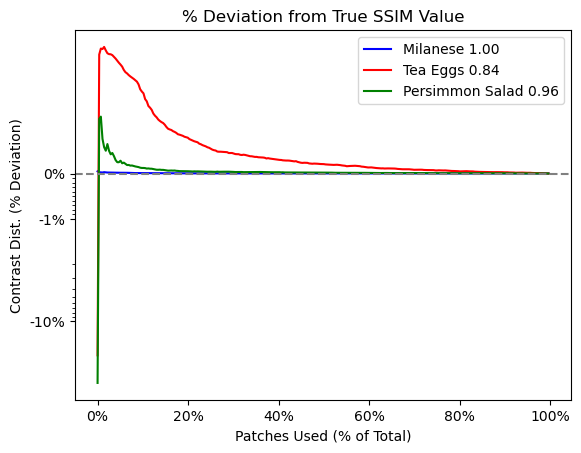

In [233]:

#plot_error_values([errors_milanese, errors_tea_eggs, errors_persimon_salad], "PSNR", 'Graphs/SPIR_PSNR.jpg')
#plot_error_values([errors_milanese, errors_tea_eggs, errors_persimon_salad], "SSIM", 'Graphs/SPIR_SSIM.jpg')

#plot_error_values([errors_milanese, errors_tea_eggs, errors_persimon_salad], "Structural Comp.", "hi")
#plot_error_values([errors_milanese, errors_tea_eggs, errors_persimon_salad], "Luminance Dist.", "hi")

plot_error_values([errors_milanese, errors_tea_eggs, errors_persimon_salad], "Contrast Dist.", "hi")

### Get the Images for the Slide Show

In [235]:
path = 'Compressed Images/tea_eggs_corrupted.jpg'

(recon_image, error) = learner_tea_eggs.SPIR(path, percent=.05, min_count=1, apply_filter=False)

  0%|          | 0/1379 [00:00<?, ?it/s]

C:\Users\raino\GitHub\Sparse-Dictionary-Learning\Classes.py:593: RuntimeWarning: invalid value encountered in floor_divide
  recon_img = recon_img // count
C:\Users\raino\GitHub\Sparse-Dictionary-Learning\Classes.py:788: RuntimeWarning: divide by zero encountered in log10
  PSNR_Corrupt = 10 * (2 * np.log10(peak_signal) - np.log10(MSE_corrupt))


In [236]:
error

51.04412360483943

In [237]:
cv2.imshow("recon Tea Eggs", recon_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [243]:
path = 'Compressed Images/milanese.jpg'
(recon_image_milanese, error) = learner_milanese.SPIR(path, percent=.05, min_count=1, apply_filter=False)
cv2.imwrite('Reconstructed Images/milanese_p=95.jpg', recon_image_milanese)
cv2.imshow("recon Milanese", recon_image_milanese)
cv2.waitKey(0)
cv2.destroyAllWindows()

  0%|          | 0/27599 [00:00<?, ?it/s]

C:\Users\raino\GitHub\Sparse-Dictionary-Learning\Classes.py:778: RuntimeWarning: divide by zero encountered in log10
  PSNR = 10 * (2 * np.log10(peak_signal) - np.log10(MSE))


In [244]:
path = 'Compressed Images/persimmon_tomato_salad_color.jpg'
(recon_image_persimmon, error) = learner_persimon_salad.SPIR(path, percent=.2, min_count=1, apply_filter=True)
cv2.imwrite('Reconstructed Images/persimmon.jpg', recon_image_persimmon)
cv2.imshow("recon persimmon", recon_image_persimmon)
cv2.waitKey(0)
cv2.destroyAllWindows()

  0%|          | 0/5519 [00:00<?, ?it/s]

C:\Users\raino\GitHub\Sparse-Dictionary-Learning\Classes.py:593: RuntimeWarning: invalid value encountered in floor_divide
  recon_img = recon_img // count


In [249]:
persimmon_color_img = load_image('Compressed Images/persimmon_tomato_salad_color.jpg')
persimmon_rb0_img = persimmon_color_img.copy()
persimmon_rb0_img[:,:,2] = 0
cv2.imshow("no green", persimmon_rb0_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [258]:
persimmon_recon_img = load_image('Reconstructed Images/persimmon.jpg')
persimmon_color_img[:,:,2].astype(int)/persimmon_color_img[:,:,2].max()
persimmon_recon_img[:,:,2].astype(int)/persimmon_recon_img[:,:,2].max()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04761905, 0.03174603, 0.        , ..., 0.04761905, 0.03174603,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [31]:
(recon, error) = learner.SPIR(path=path_corrupted, percent=.2, min_count=1, apply_filter=True)
print(f'Reconstruction Complete')
print(f'Error Est. = {error}')

cv2.imshow("Original Image", img_orig)
cv2.imshow("Corrupted Image", img_corrupt)
cv2.moveWindow("Corrupted Image", img_orig.shape[1], 0)

cv2.imshow('Reconstructed Image', recon)
cv2.waitKey(0)
cv2.destroyAllWindows()




  0%|          | 0/5519 [00:00<?, ?it/s]

C:\Users\raino\GitHub\Sparse-Dictionary-Learning\Classes.py:579: RuntimeWarning: invalid value encountered in floor_divide
  recon_img = recon_img // count


Reconstruction Complete
Error Est. = 60.32252505383432


In [9]:
print(f'Iters = 0, Error = {error}')
#print(f'Iters = 1, Error = 6.0670')
#print(f'Iters = 2, Error = 5.3670')
#print(f'Iters = 10, Error = {error}')

Iters = 0, Error = 52.24964272800685


In [6]:
cv2.imshow('temp image', recon)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
def new_test_process(test_name, N=300, K=100, I=5, L=4, P=8, save_dic = False, generate_graph = False, variabel = None):
    print(f"Test: {test_name}")
    print(f"Params: N = {N}, K = {K}, I = {I}, L = {L}, P = {P}")

    patch_shape = np.array([P, P])

    sam = Sampler(paths=paths, patch_shape=patch_shape, num_samples=N)
    learner = DictionaryLearner(L=L, K=K, sampler=sam, algo='OMP')

    # Start the timer
    start_time = time.time()

    D = learner.sparse_dictionary_learning(iters=I, output=True)

    (recon, error) = learner.SPIR(path=path, percent=percent, min_count=min_count)

    # Calculate the run time
    run_time = time.time() - start_time

    # Save the reconstruction
    correct_path = 'Reconstructed Images/' + test_name + 'N' + str(N) + 'K' + str(K) + 'I' + str(I) + 'L' + str(L) + 'P' + str(P) + '.jpg'
    cv2.imwrite(correct_path, recon)

    # Print the results
    print(f"Error = {error}, Run Time = {run_time}")

    # Save the results
    #data[(N, K, I, L, P)] = [error, run_time]

    with open('Graphs/' + test_name + '_data.pkl', 'rb') as f:
        data = pickle.load(f)

    data[(N, K, I, L, P)] = [error, run_time]

    with open('Graphs/' + test_name + '_data.pkl', 'wb') as f:
        pickle.dump(data, f)

    if save_dic:

        with open('Graphs/' + test_name + '_dictionaries.pkl', 'rb') as f:
            dictionaries = pickle.load(f)

        dictionaries[(N, K, I, L, P)] = D

        with open('Graphs/' + test_name + '_dictionaries.pkl', 'wb') as f:
            pickle.dump(data, f)

    if generate_graph:
        xs =[x[variabel] for x in list(data.keys())]
        es = [y[0] for y in list(data.values())]
        ts = [y[1] for y in list(data.values())]


        # create the figure and first axis
        fig, ax1 = plt.subplots(figsize=(8, 6))

        # create the first line and first y-axis
        ax1.plot(xs, es, linestyle='-.', marker='s', color='blue', label='Error Est.')

        X_label = ['N', 'K', 'I', 'L', 'P']
        X_label = X_label[variabel]
        ax1.set_xlabel(X_label + ' Value')

        ax1.set_ylabel('Error Est.')
        ax2 = ax1.twinx()

        ax2.plot(xs, ts, linestyle='--', marker='^', color='green', label = 'Run Time')

        # rotate and adjust second y-axis label
        ax2.yaxis.set_label_coords(1.1, 0.5)
        ax2.set_ylabel('Run Time', rotation=-90, labelpad=10)

        ax1.set_title('Run Time and Error Est. with varying ' + X_label + ' values')

        # combine legends from both axes
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2)

        # save the graph as a PNG file
        plt.savefig('Graphs/' + test_name + '.png')

        plt.show()



In [8]:
img_orig = load_image('Compressed Images/cheese_board.jpg')
img_recon = load_image('Reconstructed Images/cheese_boardL16.jpg')

img_diff = np.abs(img_orig.astype(int) - img_recon.astype(int))
img_diff = np.clip(img_diff, 0, 255).astype(np.uint8)

cv2.imshow('Original', img_orig)
cv2.imshow('Recon.', img_recon)

cv2.imshow('difference', img_diff)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [28]:
img_orig

array([[ 57,  76,  78, ...,  27,  27,  27],
       [ 40,  68,  80, ...,  34,  33,  34],
       [ 26,  61,  76, ...,  39,  39,  40],
       ...,
       [102, 106, 107, ..., 137, 123, 125],
       [106, 102, 107, ..., 112, 114, 116],
       [106, 109, 122, ..., 114, 128, 114]], dtype=uint8)

In [29]:
img_recon

array([[  1,   0,  69, ...,   0,   0,   1],
       [  0,   0,  75, ...,   1,   0,   0],
       [  1,   0,  64, ...,   1,   2,   0],
       ...,
       [  1,   0,   4, ..., 125, 134,   0],
       [  0,   3,   1, ..., 120,   0,   0],
       [  0,   1,   0, ..., 114,   2,   0]], dtype=uint8)

In [31]:
img_recon - img_orig

array([[200, 180, 247, ..., 229, 229, 230],
       [216, 188, 251, ..., 223, 223, 222],
       [231, 195, 244, ..., 218, 219, 216],
       ...,
       [155, 150, 153, ..., 244,  11, 131],
       [150, 157, 150, ...,   8, 142, 140],
       [150, 148, 134, ...,   0, 130, 142]], dtype=uint8)

In [32]:
type(img_orig)

numpy.ndarray

In [36]:
int(img_recon[0,0]) - int(img_orig[0,0])

-56

In [5]:
img_diff.max()

247

In [9]:
import pandas as pd

In [13]:
df = pd.DataFrame(columns=['Reconstructed Path', 'Original Path', 'Corrupted Path', 'Partial or Full',  'Run Time', 'MSE', 'PSNR', 'SSIM', 'Luminance Dist.', 'Contrast Dist.', 'Structural Comp.', 'MSE Gain', 'PSNR Gain', 'SSIM Gain', 'Luminance Dist. Gain', 'Contrast Dist. Gain', 'Structural Comp. Gain',  'param: K', 'param: N', 'param: Iters', 'param: L', 'param: patch_shape', 'param: other'])
df.loc[1] = {'Reconstructed Path':'hi', 'Run Time': 10}
df

,Reconstructed Path,Original Path,Corrupted Path,Partial or Full,Run Time,MSE,PSNR,SSIM,Luminance Dist.,Contrast Dist.,...,SSIM Gain,Luminance Dist. Gain,Contrast Dist. Gain,Structural Comp. Gain,param: K,param: N,param: Iters,param: L,param: patch_shape,param: other
1,hi,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df.index.max()

1

In [22]:
a = np.array([1,4,-2,0]).astype(int)
(a**2).sum()

21

In [25]:
np.log10(10)

1.0

In [35]:
df = pd.read_csv('EVALUATION_METRICS.csv')
type(df['param: Iters'][2])

numpy.float64

In [15]:
a = np.array([1,2,3])
b = np.array([1,2,4])
np.cov(a, b)

array([[1.        , 1.5       ],
       [1.5       , 2.33333333]])

In [17]:
((a - a.mean())**2)

array([1., 0., 1.])

In [19]:
a.std()**2

0.6666666666666666

In [20]:
a.var()

0.6666666666666666

In [22]:
np.cov(a, b)

array([[1.        , 1.5       ],
       [1.5       , 2.33333333]])

In [28]:
((a - a.mean() ) * (b - b.mean()) ).sum()/3

1.0

In [31]:
a = a.astype(int)
a = a / 3
a

array([0.33333333, 0.66666667, 1.        ])

In [44]:
lis = list(range(10))
random.shuffle(lis)
for i in lis: print(i)

8
0
5
3
2
9
4
1
6
7


In [51]:
0 % 100 == 0

True

In [55]:
df_new = pd.DataFrame(columns=[])
data = {}
data['hi'] = 1
df_new.loc[0.0] = data

df_new

ValueError: cannot set a frame with no defined columns

  0%|          | 0/27599 [00:00<?, ?it/s]

NameError: name 'temp_indices' is not defined

In [17]:
len([])

0